In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pykdf.kdf import save_kdf, load_kdf
from fakespikes.rates import bursts
from fakespikes.neurons import Spikes
import fakespikes.util as sp
from copy import deepcopy
import numpy as np

In [2]:
%run ../exp/fig2.py ../data/fig2

Running a)
Amp. factor 1
Amp. factor 1.5
Amp. factor 2
Amp. factor 2.5
Running b)
N bursts 2
N bursts 4
N bursts 6
N bursts 8


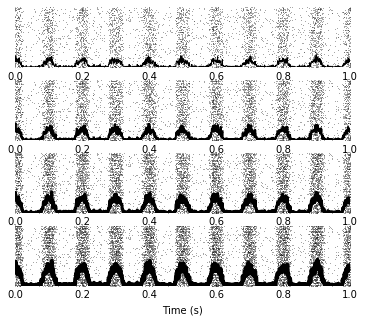

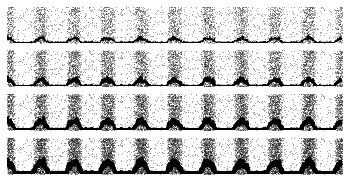

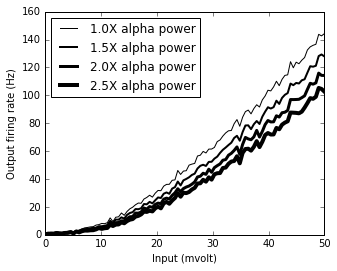

In [26]:
res_a = load_kdf('../data/fig2/a.hdf5')
fis = res_a['fis']
amps = res_a['amps']
Is = res_a['Is'] * 1000

plt.figure(figsize=(6, 5))
for k, a in enumerate(amps):
    nrns = Spikes(100, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 125 * a
    rate = bursts(times, r, res_a['f'], None, min_a=12)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    plt.plot(ts, ns, 'ok', markersize=0.2)
    
    plt.plot(times, spks.sum(1), label=str(a) + 'X alpha power', 
             linewidth=k+1, color='k')
    
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
plt.xlabel("Time (s)")

plt.figure(figsize=(6, 3))
for k, a in enumerate(amps):
    nrns = Spikes(100, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 125 * a
    rate = bursts(times, r, res_a['f'], None, min_a=12)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    plt.plot(ts, ns, 'ok', markersize=0.2)
    
    plt.plot(times, spks.sum(1), label=str(a) + 'X alpha power', 
             linewidth=k+1, color='k')
    
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
    sub.get_xaxis().set_visible(False)
plt.xlabel("Time (s)")


plt.figure(figsize=(5, 4))
for k, (a, fi) in enumerate(zip(amps, fis)):
    plt.plot(Is, fi, label=str(a) + 'X alpha power', linewidth=k+1, color='k')

plt.xlabel("Input (mvolt)")
plt.ylabel("Output firing rate (Hz)")
plt.xlim(0, 50)
plt.ylim(0,160)
plt.legend(loc='upper left')

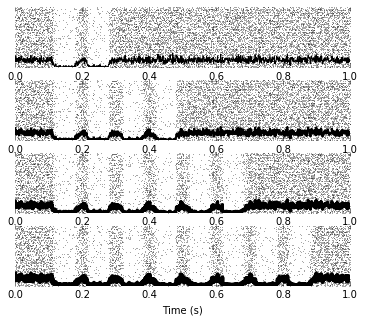

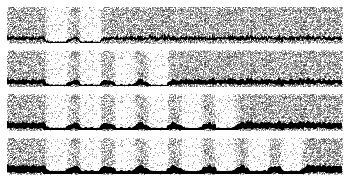

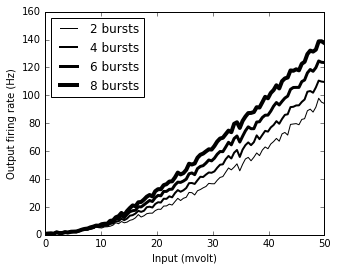

In [27]:
res_b = load_kdf('../data/fig2/b.hdf5')
fis = res_b['fis']
n_bursts = res_b['n_bursts']

# --
plt.figure(figsize=(6, 5))
ax = plt.axes(frameon=False)
for k, a in enumerate(n_bursts):
    nrns = Spikes(100, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 125 
    rate = bursts(times, r, res_a['f'], a, min_a=12)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    plt.plot(ts, ns, 'ok', markersize=0.2)
    plt.plot(times, spks.sum(1), linewidth=k+1, color='k')
    
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
plt.xlabel("Time (s)")

plt.figure(figsize=(6, 3))
ax = plt.axes(frameon=False)
for k, a in enumerate(n_bursts):
    nrns = Spikes(100, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 125 
    rate = bursts(times, r, res_a['f'], a, min_a=12)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    plt.plot(ts, ns, 'ok', markersize=0.2)
    plt.plot(times, spks.sum(1), linewidth=k+1, color='k')
    
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
    sub.get_xaxis().set_visible(False)
    
# --
plt.figure(figsize=(5, 4))
for k, (a, fi) in enumerate(zip(n_bursts, fis)):
    plt.plot(Is, fi, label=str(a) + ' bursts', linewidth=k+1, color='k')

plt.xlabel("Input (mvolt)")
plt.ylabel("Output firing rate (Hz)")
plt.xlim(0, 50)
plt.ylim(0, 160)

plt.legend(loc='upper left')

In [5]:
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    
    return y

def find_bursts(x, start=4, end=2):
    x = deepcopy(x)
#     x -= np.median(x)
#     x /= np.std(x)
    
    bursts = []
    burst = []
    b = False
    for i, xt in enumerate(x):
        # start of a burst
        if xt >= start:
            b = True
        
        if b:
            # Still bursting?
            if xt >= end:
                burst.append(i)
            else:
                # we're below the thresh. store
                bursts.append(deepcopy(burst))
            
                # and then reset
                burst = []
                b = False
        
    return bursts

In [6]:
t = 120 # seconds long
alpha = loadmat('alpha_data.mat')
times = np.linspace(0, 120, 120*500)

rest = alpha['oz_dat_rest'][0,:]
rest -= np.median(rest)

task = alpha['oz_dat_task'][0,:]
task -= np.median(task)

# smooth a little
rest = butter_bandpass_filter(rest, .1, 30, 500, order=2)
rest_pow = np.abs(hilbert(butter_bandpass_filter(rest, 8, 12, 500, order=2)))

task = butter_bandpass_filter(task, .1, 30, 500, order=2)
task_pow = np.abs(hilbert(butter_bandpass_filter(task, 8, 12, 500, order=2)))

rest_b = find_bursts(rest_pow)
task_b = find_bursts(task_pow)

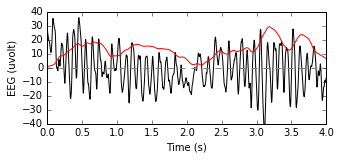

In [7]:
plt.figure(figsize=(5, 2))
plt.plot(times[:2000], rest[4000:6000], color='k')
plt.plot(times[:2000], rest_pow[4000:6000], color='r')
plt.axhline(0, color='grey', linestyle='--')
plt.ylim(-40, 40)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")

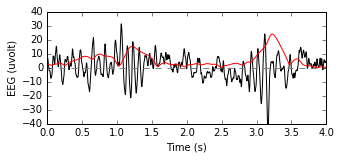

In [8]:
plt.figure(figsize=(5, 2))
plt.plot(times[:2000], task[4000:6000], color='k')
plt.plot(times[:2000], task_pow[4000:6000], color='r')
plt.axhline(0, color='grey', linestyle='--')
plt.ylim(-40, 40)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")

In [9]:
# Burst stats
print len(rest_b)
print len(task_b)

rest_b_times = [len(b) / 500. for b in rest_b]
task_b_times = [len(b) / 500. for b in task_b]

23
84


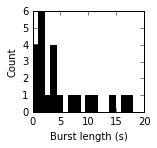

In [10]:
plt.figure(figsize=(2, 1.8))
plt.hist(rest_b_times, bins=np.linspace(0, 20, 20), color='k');
plt.xlabel("Burst length (s)")
plt.ylabel("Count")

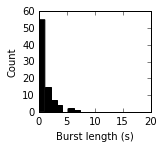

In [11]:
plt.figure(figsize=(2, 1.8))
plt.hist(task_b_times, bins=np.linspace(0, 20, 20), color='k');
plt.xlabel("Burst length (s)")
plt.ylabel("Count")